# Flow Properties
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 11/3/2021|

## Python Imports

In [65]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# AB
$\tau_S=0.1,\,\epsilon=1.0$

## Dust Density Dispersion

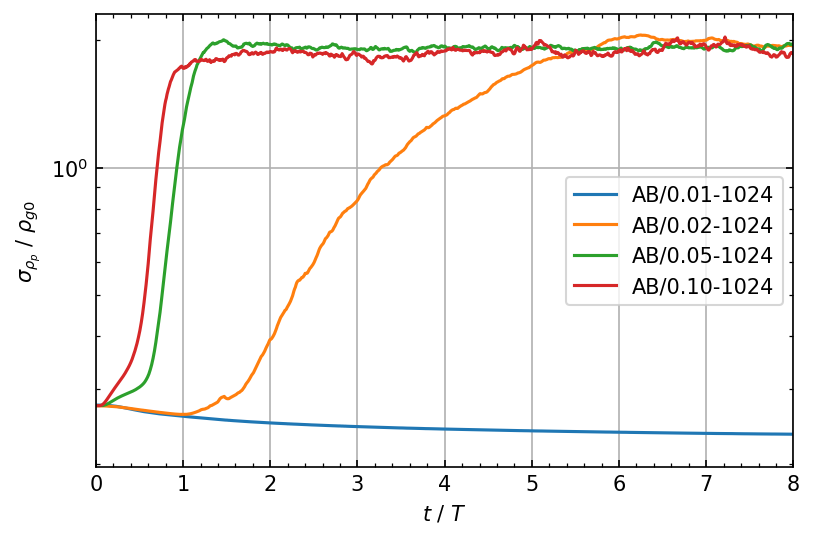

In [66]:
fig, ax = plt.subplots(dpi=150)
runs = ['AB/0.01-1024', 'AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 8))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

## Saturation Times

,Run,𝑡ₛₐₜ,𝜎ₜ
0,AB/0.02-1024,6.3,0.3
1,AB/0.05-1024,1.4,0.2
2,AB/0.10-1024,1.0,0.1


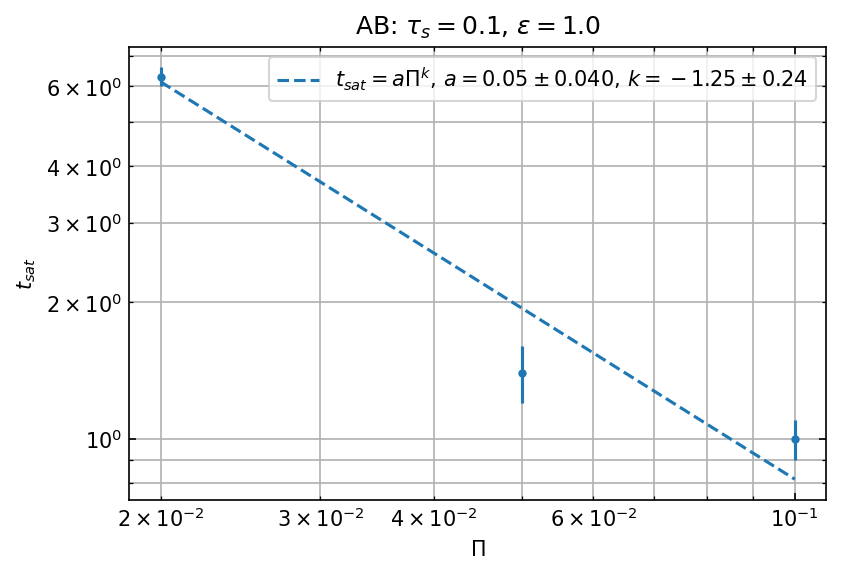

In [67]:
fig, ax = plt.subplots(dpi=150)
title = 'AB'
runs = ['AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']
Πs = np.zeros(len(runs))
t_sats = [6.3, 1.4, 1.0]
σt_sats = [0.3, 0.2, 0.1]
func = lambda x, a, k : a*x**k # power-law model function

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    Πs[i] = athinput['problem']['duy0']    # global rad. press. grad.
    Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
    τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
    ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
popt, pcov = curve_fit(func, Πs, t_sats, sigma=σt_sats)
perr = np.sqrt(np.diag(pcov))
subs = r'$t_{sat}$'
label = subs+r'$=a\Pi^k,\,a={:.2f}\pm{:.3f},\,k={:.2f}\pm{:.2f}$'.format(
        popt[0], perr[0], popt[1], perr[1])
ax.errorbar(Πs, t_sats, σt_sats, fmt='.')
ax.plot(Πs, func(Πs, *popt), ls='--', color='tab:blue', label=label)

ax.set(xlabel=r'$\Pi$', ylabel=r'$t_{sat}$', xscale='log', yscale='log',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '𝑡ₛₐₜ': t_sats,
    '𝜎ₜ': σt_sats,})
df.style.format({
    '𝑡ₛₐₜ': '{:.1f}',
    '𝜎ₜ': '{:.1f}',})

## Turbulent Mach Number (Gas)

,Run,Ma_x,𝜎_Ma_x,Ma_y,𝜎_Ma_y,Ma_z,𝜎_Ma_z
0,AB/0.02-1024,4.5e-03,2.5e-04,2.6e-03,1.2e-03,2.4e-03,1.2e-03
1,AB/0.05-1024,1.1e-02,2.3e-04,5.4e-03,2.6e-04,7.6e-03,4.7e-04
2,AB/0.10-1024,2.3e-02,1.6e-03,9.8e-03,1.1e-03,1.5e-02,1.3e-03


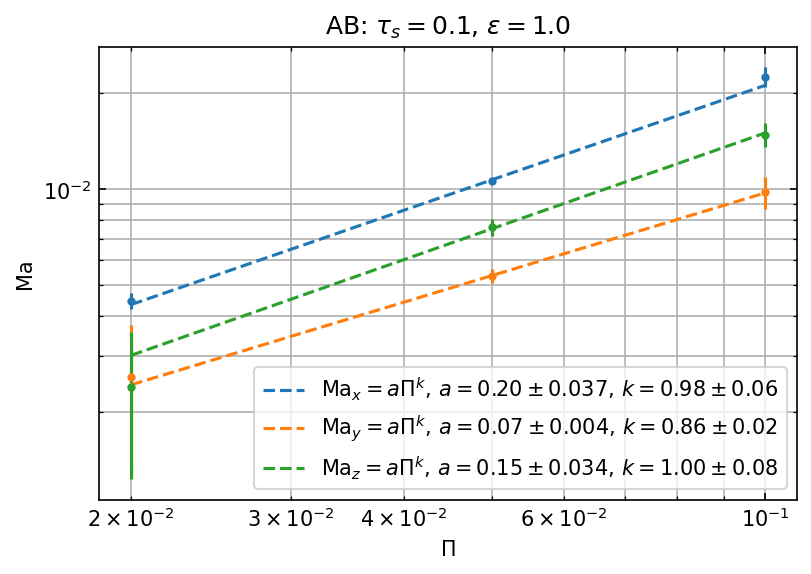

In [68]:
fig, ax = plt.subplots(dpi=150)
dirs = [['x', 'dux',   'dux2', 1, 'tab:blue'],
        ['y', 'duy',   'duy2', 1, 'tab:orange'],
        ['z', '2-mom', '2-KE', 2, 'tab:green']]
title = 'AB'
runs = ['AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']
Πs = np.zeros(len(runs))
Mas, σMas= np.zeros((len(runs), len(dirs))), np.zeros((len(runs), len(dirs)))
t_sat = [6, 1.4, 1] # [T]
func = lambda x, a, k : a*x**k # power-law model function

for i,dir in enumerate(dirs):
    for j,run in enumerate(runs):
        athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
        dt = athinput['output3']['dt']         # time between hst outputs
        i_sat = int(t_sat[i] / dt)             # output index of sat. state
        Πs[j] = athinput['problem']['duy0']    # global rad. press. grad.
        Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
        τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
        ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
        hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
        mass = hst['mass']
        disp = np.sqrt(dir[3]*hst[dir[2]]/mass - (hst[dir[1]]/mass)**2)
        Ma = disp/athinput['hydro']['iso_sound_speed']
        Mas[j,i] = np.average(Ma[i_sat:])
        σMas[j,i] = np.std(Ma[i_sat:])
    popt, pcov = curve_fit(func, Πs, Mas[:,i], sigma=σMas[:,i])
    perr = np.sqrt(np.diag(pcov))
    label = r'Ma$_{:s}=a\Pi^k,\,a={:.2f}\pm{:.3f},\,k={:.2f}\pm{:.2f}$'.format(
            dir[0], popt[0], perr[0], popt[1], perr[1])
    ax.errorbar(Πs, Mas[:,i], σMas[:,i], fmt='.')
    ax.plot(Πs, func(Πs, *popt), ls='--', color=dir[4], label=label)

ax.set(xlabel=r'$\Pi$', ylabel='Ma', xscale='log', yscale='log',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    'Ma_x': Mas[:,0],
    '𝜎_Ma_x': σMas[:,0],
    'Ma_y': Mas[:,1],
    '𝜎_Ma_y': σMas[:,1],
    'Ma_z': Mas[:,2],
    '𝜎_Ma_z': σMas[:,2]})
df.style.format({
    'Ma_x': '{:.1e}',
    '𝜎_Ma_x': '{:.1e}',
    'Ma_y': '{:.1e}',
    '𝜎_Ma_y': '{:.1e}',
    'Ma_z': '{:.1e}',
    '𝜎_Ma_z': '{:.1e}'})

## Dust Velocities

### Radial

,Run,⟨𝑣ₓ⟩ / 𝜂𝑣_K,𝜎_𝑣ₓ / 𝜂𝑣_K,𝑣₀ₓ / 𝜂𝑣_K,⟨𝑑𝑣ₓ⟩ / 𝜂𝑣_K,𝜎_𝑑𝑣ₓ / 𝜂𝑣_K
0,AB/0.02-1024,-0.102,0.002,-0.050,0.178,0.007
1,AB/0.05-1024,-0.107,0.003,-0.050,0.170,0.006
2,AB/0.10-1024,-0.107,0.007,-0.050,0.168,0.015


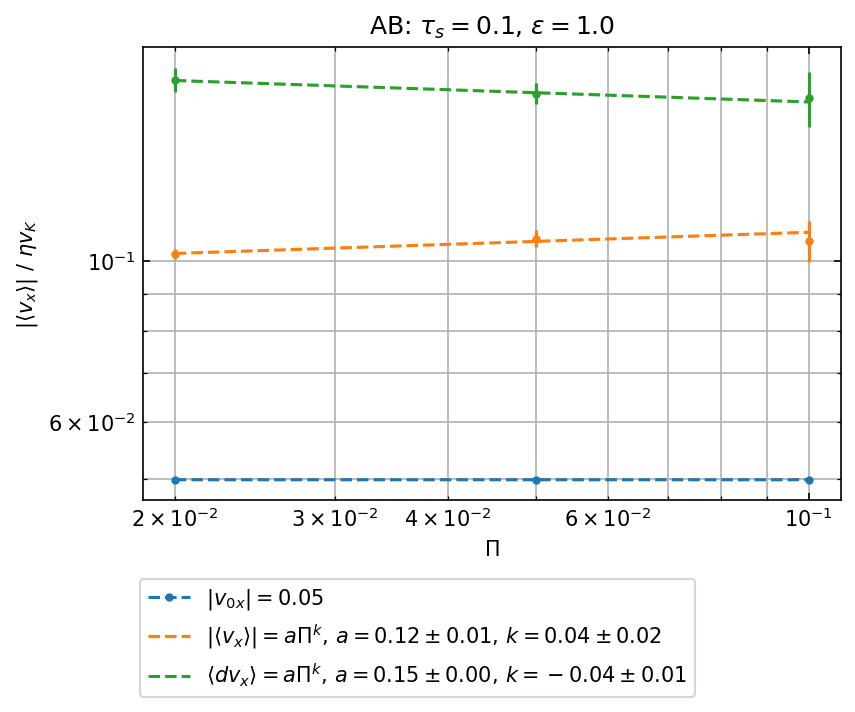

In [69]:
title = 'AB'
runs = ['AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']
Πs = np.zeros(len(runs))
v0xs = np.zeros(len(runs))                             # initial velocities
vxs, σvxs = np.zeros(len(runs)), np.zeros(len(runs))   # saturation velocities
dvxs, σdvxs = np.zeros(len(runs)), np.zeros(len(runs)) # velocity dispersion
t_sat = [6, 1.4, 1] # [T]

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    dt = athinput['output3']['dt']         # time between hst outputs
    i_sat = int(t_sat[i] / dt)             # output index of sat. state
    Np_tot = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3']  # total number of particles
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Ly = (athinput['mesh']['x3max'] - athinput['mesh']['x3min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    V = Lx*Ly*Lz # domain volume [H³]
    Πs[i] = athinput['problem']['duy0']    # global rad. press. grad.
    Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
    τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
    ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    ηv_K = Πs[i]*athinput['hydro']['iso_sound_speed']
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    v0xs[i] = hst['vp1'][0]/ηv_K/Np_tot
    vxs[i] = np.average(hst['vp1'][i_sat:])/ηv_K/Np_tot
    σvxs[i] = np.std(hst['vp1'][i_sat:])/ηv_K/Np_tot
    disp = np.sqrt(hst['dvpx2']/ε/V - (hst['dvpx']/ε/V)**2)
    dvxs[i] = np.average(disp[i_sat:])/ηv_K
    σdvxs[i] = np.std(disp[i_sat:])/ηv_K

func = lambda x, a, k : a*x**k # power-law model function
popt, pcov = curve_fit(func, Πs, np.abs(vxs), sigma=σvxs)
poptd, pcovd = curve_fit(func, Πs, np.abs(dvxs), sigma=σdvxs)
perr = np.sqrt(np.diag(pcov))
perrd = np.sqrt(np.diag(pcovd))
label0 = r'$|v_0$$_x|={:.2f}$'.format(np.abs(v0xs[0]))
label = r'$|\langle v_x\rangle|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        popt[0], perr[0], popt[1], perr[1])
dlabel = r'$\langle dv_x\rangle=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        poptd[0], perrd[0], poptd[1], perrd[1])
fig, ax = plt.subplots(dpi=150)
ax.plot(Πs, np.abs(v0xs), marker='.', ls='--', label=label0)
ax.errorbar(Πs, np.abs(vxs), σvxs, fmt='.')
ax.errorbar(Πs, np.abs(dvxs), σdvxs, fmt='.')
ax.plot(Πs, func(Πs, *popt), ls='--', color='tab:orange', label=label)
ax.plot(Πs, func(Πs, *poptd), ls='--', color='tab:green', label=dlabel)
ax.set(xlabel=r'$\Pi$', ylabel=r'$|\langle v_x \rangle|$ / $\eta v_K$',
       xscale='log', yscale='log',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend(bbox_to_anchor=(-0.02, -0.15), loc='upper left')
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '⟨𝑣ₓ⟩ / 𝜂𝑣_K': vxs,
    '𝜎_𝑣ₓ / 𝜂𝑣_K': σvxs,
    '𝑣₀ₓ / 𝜂𝑣_K': v0xs,
    '⟨𝑑𝑣ₓ⟩ / 𝜂𝑣_K': dvxs,
    '𝜎_𝑑𝑣ₓ / 𝜂𝑣_K': σdvxs})
df.style.format({
    '⟨𝑣ₓ⟩ / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑣ₓ / 𝜂𝑣_K': '{:.3f}',
    '𝑣₀ₓ / 𝜂𝑣_K': '{:.3f}',
    '⟨𝑑𝑣ₓ⟩ / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑑𝑣ₓ / 𝜂𝑣_K': '{:.3f}'})

# BA
$\tau_S=1.0,\,\epsilon=0.2$

## Dust Density Dispersion

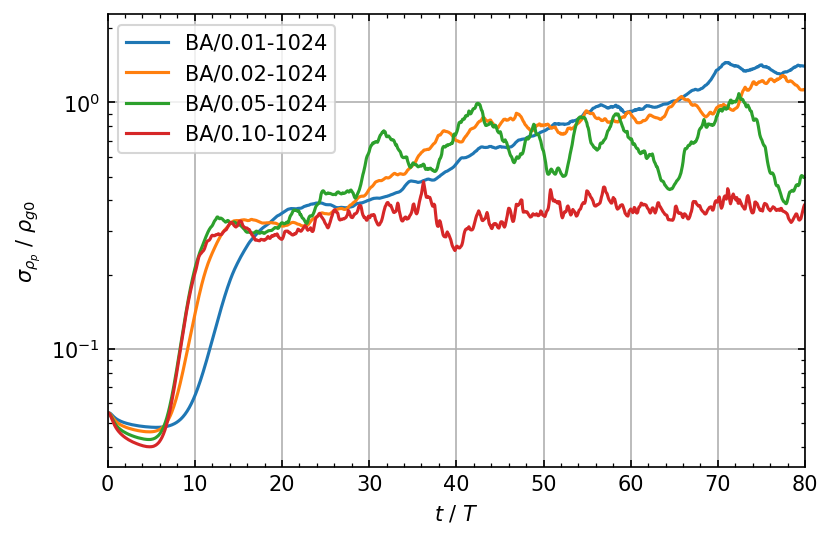

In [70]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 80))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

## Saturation Times

,Run,𝑡ₛₐₜ,𝜎ₜ
0,BA/0.01-1024,24.0,2.0
1,BA/0.02-1024,16.0,2.0
2,BA/0.05-1024,12.0,1.0
3,BA/0.10-1024,11.0,2.0


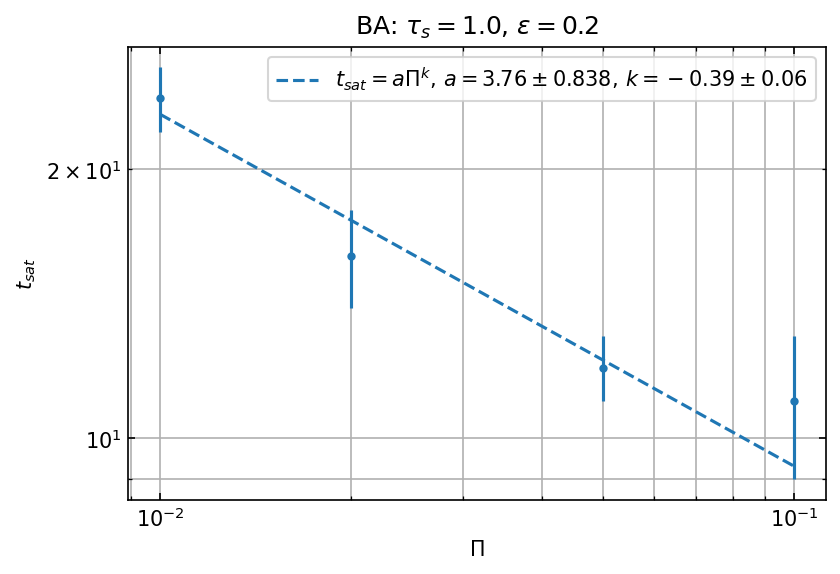

In [71]:
fig, ax = plt.subplots(dpi=150)
title = 'BA'
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Πs = np.zeros(len(runs))
t_sats = [24, 16, 12, 11]
σt_sats = [2, 2, 1, 2]
func = lambda x, a, k : a*x**k # power-law model function

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    Πs[i] = athinput['problem']['duy0']    # global rad. press. grad.
    Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
    τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
    ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
popt, pcov = curve_fit(func, Πs, t_sats, sigma=σt_sats)
perr = np.sqrt(np.diag(pcov))
subs = r'$t_{sat}$'
label = subs+r'$=a\Pi^k,\,a={:.2f}\pm{:.3f},\,k={:.2f}\pm{:.2f}$'.format(
        popt[0], perr[0], popt[1], perr[1])
ax.errorbar(Πs, t_sats, σt_sats, fmt='.')
ax.plot(Πs, func(Πs, *popt), ls='--', color='tab:blue', label=label)

ax.set(xlabel=r'$\Pi$', ylabel=r'$t_{sat}$', xscale='log', yscale='log',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '𝑡ₛₐₜ': t_sats,
    '𝜎ₜ': σt_sats,})
df.style.format({
    '𝑡ₛₐₜ': '{:.1f}',
    '𝜎ₜ': '{:.1f}',})

## Turbulent Mach Number (Gas)

,Run,Ma_x,𝜎_Ma_x,Ma_y,𝜎_Ma_y,Ma_z,𝜎_Ma_z
0,BA/0.01-1024,2.0e-03,8.2e-05,4.0e-03,1.1e-03,8.1e-03,3.1e-03
1,BA/0.02-1024,4.4e-03,2.5e-04,7.3e-03,1.8e-03,1.4e-02,5.1e-03
2,BA/0.05-1024,1.1e-02,9.0e-04,1.6e-02,2.7e-03,3.4e-02,9.7e-03
3,BA/0.10-1024,2.3e-02,1.4e-03,2.6e-02,4.2e-03,5.2e-02,1.7e-02


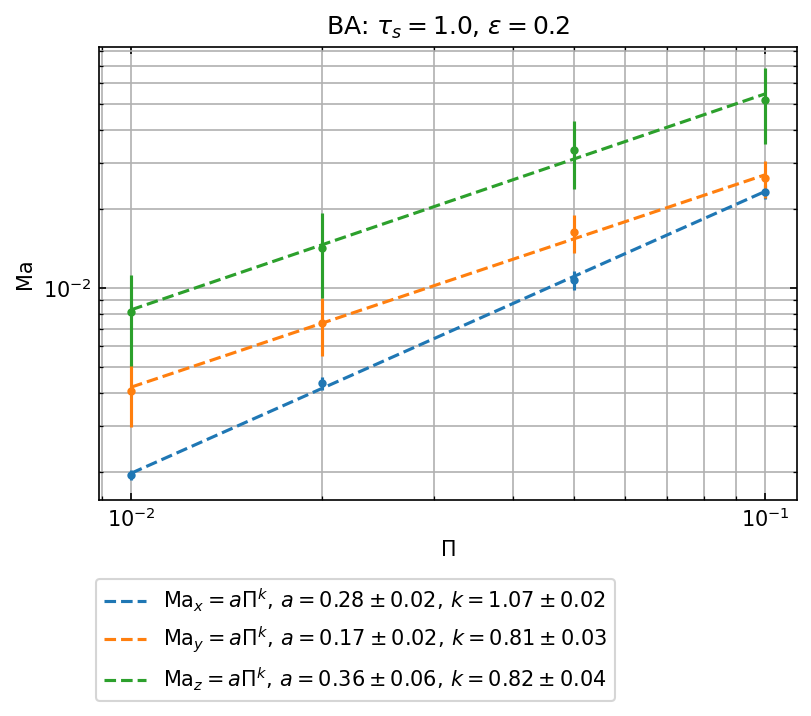

In [72]:
fig, ax = plt.subplots(dpi=150)
dirs = [['x', 'dux',   'dux2', 1, 'tab:blue'],
        ['y', 'duy',   'duy2', 1, 'tab:orange'],
        ['z', '2-mom', '2-KE', 2, 'tab:green']]
title = 'BA'
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Πs = np.zeros(len(runs))
Mas, σMas= np.zeros((len(runs), len(dirs))), np.zeros((len(runs), len(dirs)))
t_sat = [20, 16, 12, 12] # [T]
func = lambda x, a, k : a*x**k # power-law model function

for i,dir in enumerate(dirs):
    for j,run in enumerate(runs):
        athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
        dt = athinput['output3']['dt']         # time between hst outputs
        i_sat = int(t_sat[i] / dt)             # output index of sat. state
        Πs[j] = athinput['problem']['duy0']    # global rad. press. grad.
        Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
        τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
        ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
        hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
        mass = hst['mass']
        disp = np.sqrt(dir[3]*hst[dir[2]]/mass - (hst[dir[1]]/mass)**2)
        Ma = disp/athinput['hydro']['iso_sound_speed']
        Mas[j,i] = np.average(Ma[i_sat:])
        σMas[j,i] = np.std(Ma[i_sat:])
    popt, pcov = curve_fit(func, Πs, Mas[:,i], sigma=σMas[:,i])
    perr = np.sqrt(np.diag(pcov))
    label = r'Ma$_{:s}=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
            dir[0], popt[0], perr[0], popt[1], perr[1])
    ax.errorbar(Πs, Mas[:,i], σMas[:,i], fmt='.')
    ax.plot(Πs, func(Πs, *popt), ls='--', color=dir[4], label=label)

ax.set(xlabel=r'$\Pi$', ylabel='Ma', xscale='log', yscale='log',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend(bbox_to_anchor=(-0.02, -0.15), loc='upper left')
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    'Ma_x': Mas[:,0],
    '𝜎_Ma_x': σMas[:,0],
    'Ma_y': Mas[:,1],
    '𝜎_Ma_y': σMas[:,1],
    'Ma_z': Mas[:,2],
    '𝜎_Ma_z': σMas[:,2]})
df.style.format({
    'Ma_x': '{:.1e}',
    '𝜎_Ma_x': '{:.1e}',
    'Ma_y': '{:.1e}',
    '𝜎_Ma_y': '{:.1e}',
    'Ma_z': '{:.1e}',
    '𝜎_Ma_z': '{:.1e}'})

## Dust Velocities

,Run,𝜂𝑣_K / HT⁻¹,⟨𝑣ₓ⟩ / 𝜂𝑣_K,𝜎_𝑣ₓ / 𝜂𝑣_K,𝑣₀ₓ / 𝜂𝑣_K,⟨𝑑𝑣ₓ⟩ / 𝜂𝑣_K,𝜎_𝑑𝑣ₓ / 𝜂𝑣_K
0,BA/0.01-1024,0.063,-0.417,0.112,-0.820,0.329,0.029
1,BA/0.02-1024,0.126,-0.469,0.121,-0.820,0.329,0.038
2,BA/0.05-1024,0.314,-0.588,0.059,-0.820,0.329,0.048
3,BA/0.10-1024,0.628,-0.668,0.035,-0.820,0.299,0.053


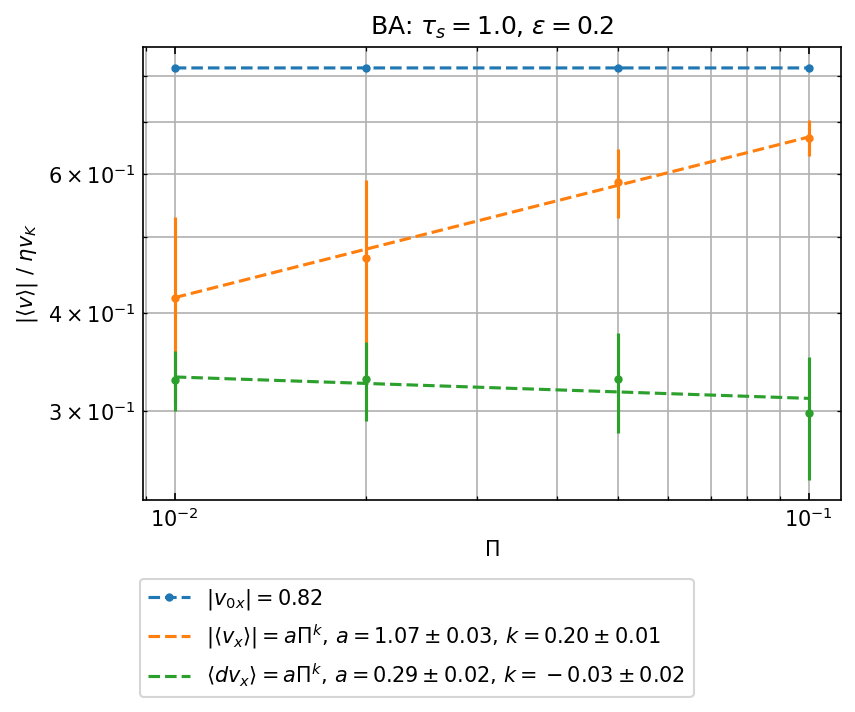

In [128]:
title = 'BA'
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Πs, ηv_Ks = np.zeros(len(runs)), np.zeros(len(runs))
v0xs = np.zeros(len(runs))                                 # init. rad. velocities
vxs, σvxs = np.zeros(len(runs)), np.zeros(len(runs))       # sat. rad. velocities
dvxs, σdvxs = np.zeros(len(runs)), np.zeros(len(runs))     # rad. vel. dispersion
t_sat = [20, 16, 12, 12]                                   # [T]

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    dt = athinput['output3']['dt']         # time between hst outputs
    i_sat = int(t_sat[i] / dt)             # output index of sat. state
    Np_tot = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3']  # total number of particles
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Ly = (athinput['mesh']['x3max'] - athinput['mesh']['x3min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    V = Lx*Ly*Lz                           # domain volume [H³]
    Πs[i] = athinput['problem']['duy0']    # global rad. press. grad.
    Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
    τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
    ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    ηv_K = Πs[i]*athinput['hydro']['iso_sound_speed']
    ηv_Ks[i] = ηv_K
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    v0xs[i] = hst['vp1'][0]/ηv_K/Np_tot
    vxs[i] = np.average(hst['vp1'][i_sat:])/ηv_K/Np_tot
    σvxs[i] = np.std(hst['vp1'][i_sat:])/ηv_K/Np_tot
    disp = np.sqrt(hst['dvpx2']/ε/V - (hst['dvpx']/ε/V)**2)
    dvxs[i] = np.average(disp[i_sat:])/ηv_K
    σdvxs[i] = np.std(disp[i_sat:])/ηv_K

func = lambda x, a, k : a*x**k # power-law model function
popt, pcov = curve_fit(func, Πs, np.abs(vxs), sigma=σvxs)
poptd, pcovd = curve_fit(func, Πs, np.abs(dvxs), sigma=σdvxs)
perr = np.sqrt(np.diag(pcov))
perrd = np.sqrt(np.diag(pcovd))
label0 = r'$|v_0$$_x|={:.2f}$'.format(np.abs(v0xs[0]))
label = r'$|\langle v_x\rangle|=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        popt[0], perr[0], popt[1], perr[1])
dlabel = r'$\langle dv_x\rangle=a\Pi^k,\,a={:.2f}\pm{:.2f},\,k={:.2f}\pm{:.2f}$'.format(
        poptd[0], perrd[0], poptd[1], perrd[1])

fig, ax = plt.subplots(dpi=150)
ax.plot(Πs, np.abs(v0xs), marker='.', ls='--', label=label0)
ax.errorbar(Πs, np.abs(vxs), σvxs, fmt='.')
ax.errorbar(Πs, np.abs(dvxs), σdvxs, fmt='.')
ax.plot(Πs, func(Πs, *popt), ls='--', color='tab:orange', label=label)
ax.plot(Πs, func(Πs, *poptd), ls='--', color='tab:green', label=dlabel)
ax.set(xlabel=r'$\Pi$', ylabel=r'$|\langle v \rangle|$ / $\eta v_K$',
       xscale='log', yscale='log',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend(bbox_to_anchor=(-0.02, -0.15), loc='upper left')
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '𝜂𝑣_K / HT⁻¹': ηv_Ks,
    '⟨𝑣ₓ⟩ / 𝜂𝑣_K': vxs,
    '𝜎_𝑣ₓ / 𝜂𝑣_K': σvxs,
    '𝑣₀ₓ / 𝜂𝑣_K': v0xs,
    '⟨𝑑𝑣ₓ⟩ / 𝜂𝑣_K': dvxs,
    '𝜎_𝑑𝑣ₓ / 𝜂𝑣_K': σdvxs})
df.style.format({
    '𝜂𝑣_K / HT⁻¹': '{:.3f}',
    '⟨𝑣ₓ⟩ / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑣ₓ / 𝜂𝑣_K': '{:.3f}',
    '𝑣₀ₓ / 𝜂𝑣_K': '{:.3f}',
    '⟨𝑑𝑣ₓ⟩ / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑑𝑣ₓ / 𝜂𝑣_K': '{:.3f}'})

## Group Velocities

### Radial

#### Formulae
\begin{aligned}
\Delta x &= x_1 - x_0\\
\sigma_{\Delta x} &= (\sigma_{x_0}^2 + \sigma_{x_1}^2)^{1/2}\\
\Delta t &= t_1 - t_0\\
v_x &= \Delta x/\Delta t\\
\sigma_{v_x} &= v_x\frac{\sigma_{\Delta x}}{\Delta x} = \frac{\sigma_{\Delta x}}{\Delta t}
\end{aligned}

#### $\Pi = 0.01$

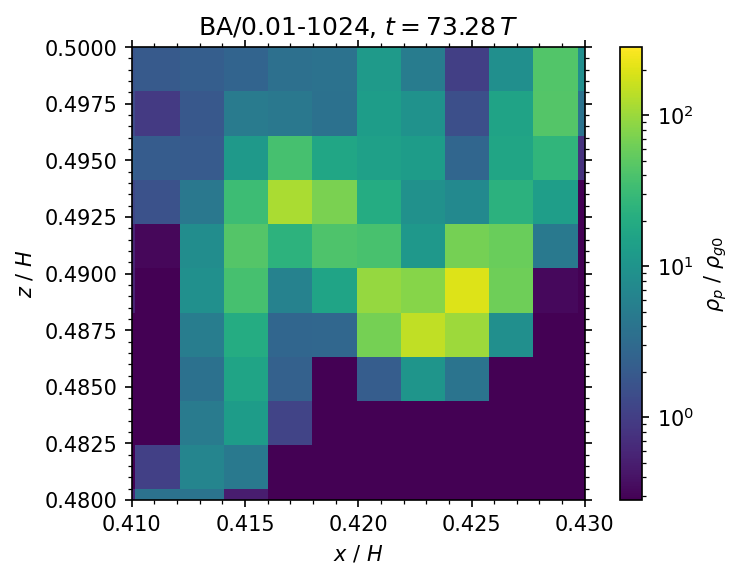

In [105]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.01-1024'
vmag = 1e3
xlim, ylim =(0.41, 0.43), (0.48, 0.50)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01832.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_0 = 0.42 \pm 0.01\,H$
- $t_0 = 73.28\,T$

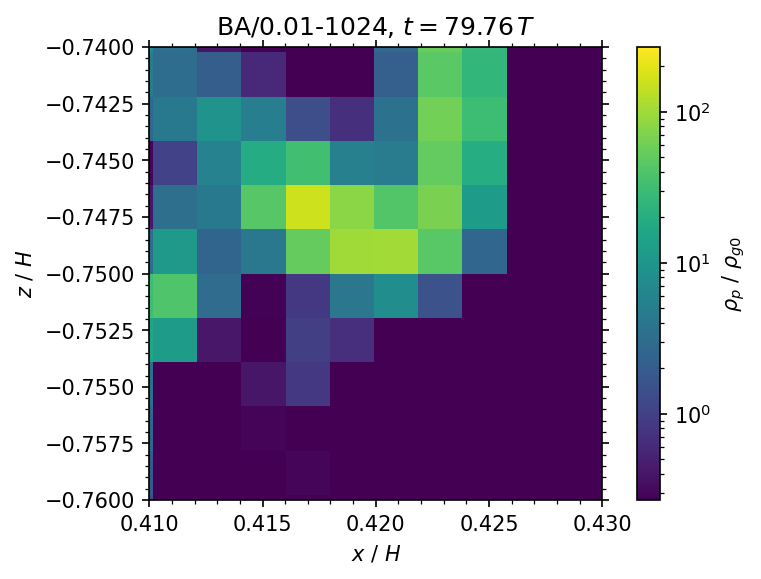

In [108]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.01-1024'
vmag = 1e3
xlim, ylim =(0.41, 0.43), (-0.76, -0.74)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01994.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_1 = 0.42 \pm 0.01\,H$
- $t_1 = 79.76\,T$

In [152]:
run = 'BA/0.01-1024'
x0, x1 = 0.42, 0.42   # [H]
σx0, σx1 = 0.01, 0.01 # [H]
t0, t1 = 73.28, 79.76 # [T]
Δx = x1 - x0
σΔx = np.sqrt(σx0**2 + σx1**2)
Δt = t1 - t0
vx = Δx/Δt
σvx = σΔx/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑥 = {Δx:.2f} H')
print(f' 𝜎_Δ𝑥 = {σΔx:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑥 =    {vx:.2f} H/T = {vx/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑥 = {σvx:.1e} H/T = {σvx/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑥 = 0.00 H
 𝜎_Δ𝑥 = 0.01 H
   Δ𝑡 = 6.48 T
  𝑣_𝑥 =    0.00 H/T = 0.00 𝜂𝑣_K
𝜎_𝑣_𝑥 = 2.2e-03 H/T = 0.03 𝜂𝑣_K


#### $\Pi = 0.02$

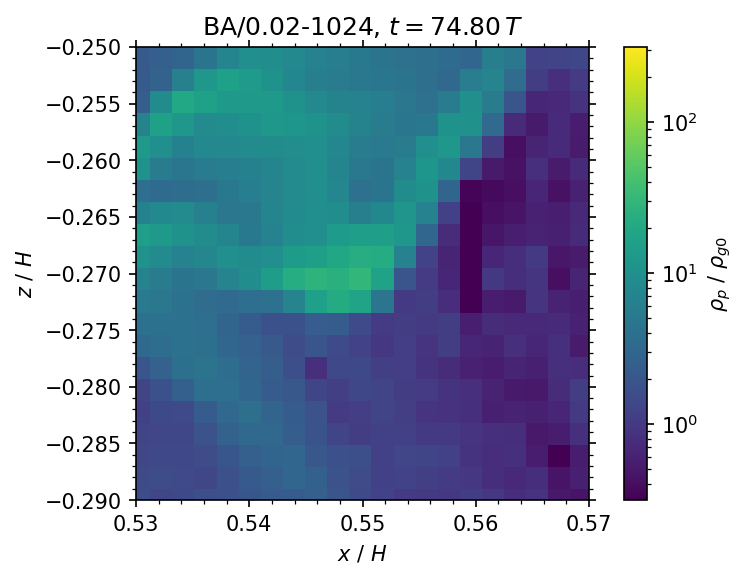

In [113]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.02-1024'
vmag = 1e3
xlim, ylim =(0.53, 0.57), (-0.29, -0.25)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01870.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_0 = 0.55 \pm 0.02\,H$
- $t_0 = 74.80\,T$

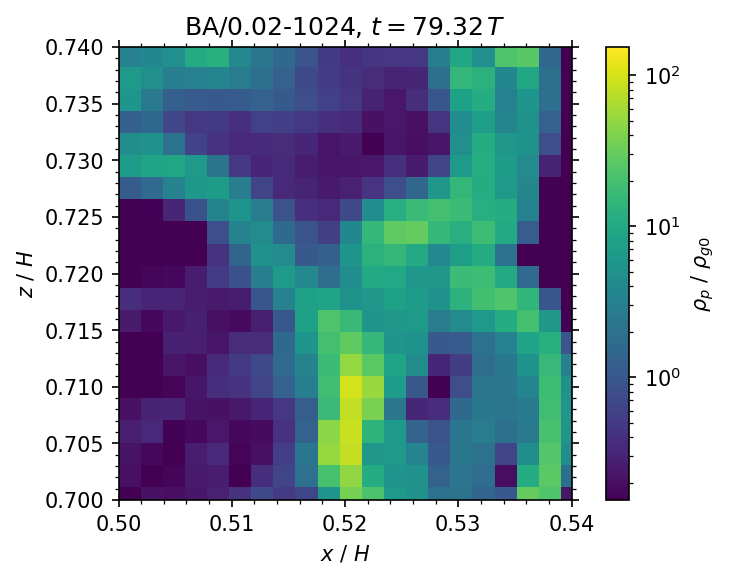

In [116]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.02-1024'
vmag = 1e3
xlim, ylim =(0.50, 0.54), (0.70, 0.74)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01983.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_1 = 0.52 \pm 0.02\,H$
- $t_1 = 79.32\,T$

In [153]:
run = 'BA/0.02-1024'
x0, x1 = 0.55, 0.52   # [H]
σx0, σx1 = 0.02, 0.02 # [H]
t0, t1 = 74.80, 79.32 # [T]
Δx = x1 - x0
σΔx = np.sqrt(σx0**2 + σx1**2)
Δt = t1 - t0
vx = Δx/Δt
σvx = σΔx/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑥 = {Δx:.2f} H')
print(f' 𝜎_Δ𝑥 = {σΔx:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑥 =    {vx:.2f} H/T = {vx/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑥 = {σvx:.1e} H/T = {σvx/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑥 = -0.03 H
 𝜎_Δ𝑥 = 0.03 H
   Δ𝑡 = 4.52 T
  𝑣_𝑥 =    -0.01 H/T = -0.05 𝜂𝑣_K
𝜎_𝑣_𝑥 = 6.3e-03 H/T = 0.05 𝜂𝑣_K


#### $\Pi = 0.05$

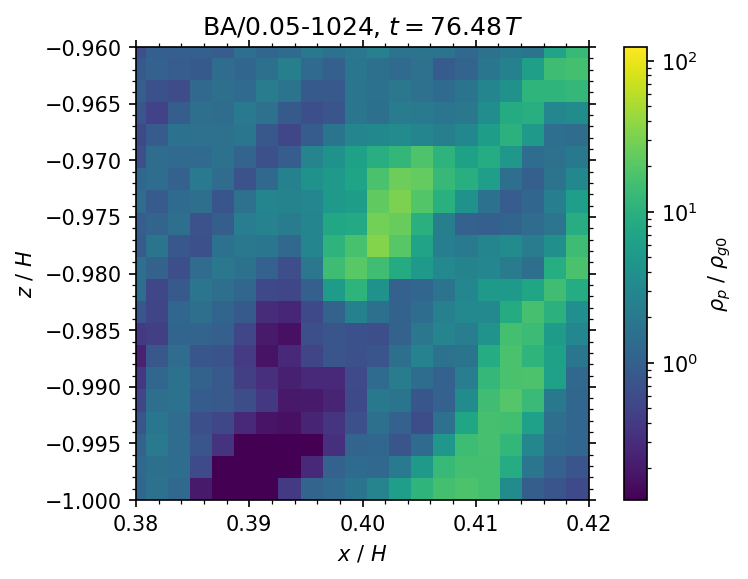

In [118]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.05-1024'
vmag = 1e3
xlim, ylim =(0.38, 0.42), (-1.00, -0.96)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01912.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_0 = 0.40 \pm 0.02\,H$
- $t_0 = 76.48\,T$

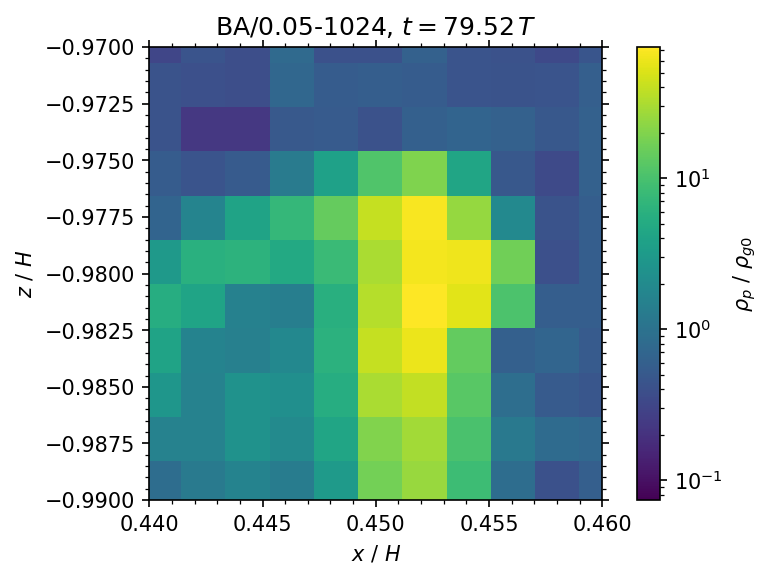

In [121]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.05-1024'
vmag = 1e3
xlim, ylim =(0.44, 0.46), (-0.99, -0.97)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01988.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_1 = 0.45 \pm 0.01\,H$
- $t_1 = 79.52\,T$

In [154]:
run = 'BA/0.05-1024'
x0, x1 = 0.40, 0.45   # [H]
σx0, σx1 = 0.02, 0.01 # [H]
t0, t1 = 76.48, 79.52 # [T]
Δx = x1 - x0
σΔx = np.sqrt(σx0**2 + σx1**2)
Δt = t1 - t0
vx = Δx/Δt
σvx = σΔx/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑥 = {Δx:.2f} H')
print(f' 𝜎_Δ𝑥 = {σΔx:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑥 =    {vx:.2f} H/T = {vx/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑥 = {σvx:.1e} H/T = {σvx/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑥 = 0.05 H
 𝜎_Δ𝑥 = 0.02 H
   Δ𝑡 = 3.04 T
  𝑣_𝑥 =    0.02 H/T = 0.05 𝜂𝑣_K
𝜎_𝑣_𝑥 = 7.4e-03 H/T = 0.02 𝜂𝑣_K


#### $\Pi = 0.10$

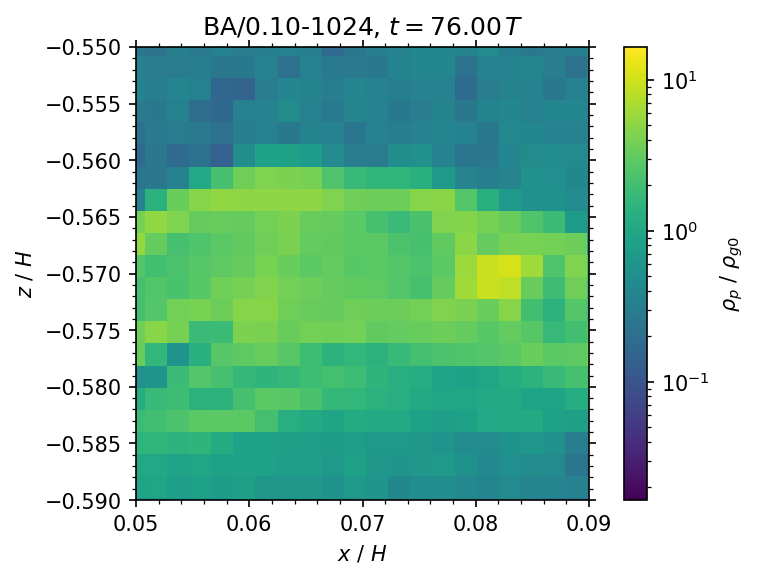

In [124]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.10-1024'
vmag = 1e3
xlim, ylim =(0.05, 0.09), (-0.59, -0.55)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01900.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_0 = 0.07 \pm 0.02\,H$
- $t_0 = 76.00\,T$

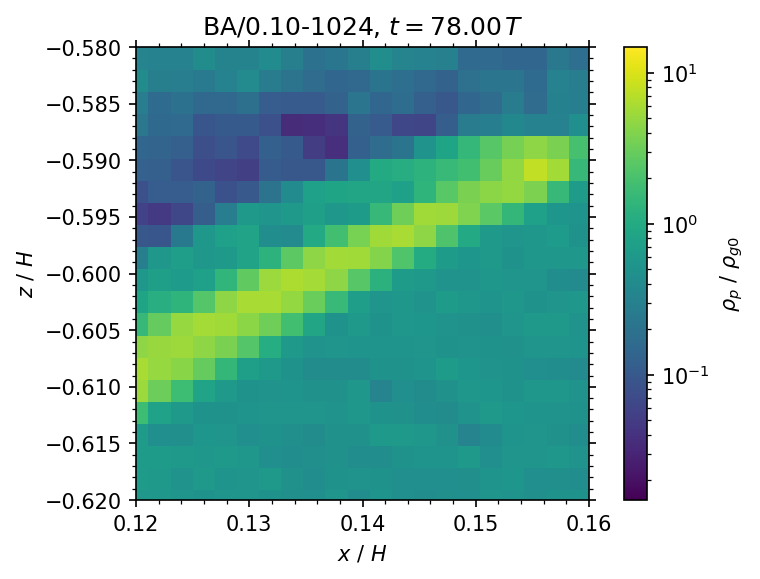

In [126]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.10-1024'
vmag = 1e3
xlim, ylim =(0.12, 0.16), (-0.62, -0.58)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out2.01950.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

- $x_1 = 0.14 \pm 0.02\,H$
- $t_1 = 78.00\,T$

In [155]:
run = 'BA/0.10-1024'
x0, x1 = 0.07, 0.14   # [H]
σx0, σx1 = 0.02, 0.02 # [H]
t0, t1 = 76.00, 78.00 # [T]
Δx = x1 - x0
σΔx = np.sqrt(σx0**2 + σx1**2)
Δt = t1 - t0
vx = Δx/Δt
σvx = σΔx/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑥 = {Δx:.2f} H')
print(f' 𝜎_Δ𝑥 = {σΔx:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑥 =    {vx:.2f} H/T = {vx/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑥 = {σvx:.1e} H/T = {σvx/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑥 = 0.07 H
 𝜎_Δ𝑥 = 0.03 H
   Δ𝑡 = 2.00 T
  𝑣_𝑥 =    0.04 H/T = 0.06 𝜂𝑣_K
𝜎_𝑣_𝑥 = 1.4e-02 H/T = 0.02 𝜂𝑣_K


### Vertical

#### Formulae
\begin{aligned}
\Delta z &= z_1 - z_0\\
\sigma_{\Delta z} &= (\sigma_{z_0}^2 + \sigma_{z_1}^2)^{1/2}\\
\Delta t &= t_1 - t_0\\
v_z &= \Delta z/\Delta t\\
\sigma_{v_z} &= v_z\frac{\sigma_{\Delta z}}{\Delta z} = \frac{\sigma_{\Delta z}}{\Delta t}
\end{aligned}

#### $\Pi = 0.01$
![mt0](vzs/BA/0.01-1024/mt0.png)
- $z_0 = 0.50 \pm 0.02\,H$
- $t_0 = 73.28\,T$

![mt1](vzs/BA/0.01-1024/mt1.png)
- $z_1 = 1.25 \pm 0.02\,H$
- $t_1 = 79.76\,T$

In [73]:
run = 'BA/0.01-1024'
z0, z1 = 0.50, 1.25   # [H]
σz0, σz1 = 0.02, 0.02 # [H]
t0, t1 = 73.28, 79.76 # [T]
Δz = z1 - z0
σΔz = np.sqrt(σz0**2 + σz1**2)
Δt = t1 - t0
vz = Δz/Δt
σvz = σΔz/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑧 = {Δz:.2f} H')
print(f' 𝜎_Δ𝑧 = {σΔz:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑧 =    {vz:.2f} H/T = {vz/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑧 = {σvz:.1e} H/T = {σvz/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑧 = 0.75 H
 𝜎_Δ𝑧 = 0.03 H
   Δ𝑡 = 6.48 T
  𝑣_𝑧 =    0.12 H/T = 1.84 𝜂𝑣_K
𝜎_𝑣_𝑧 = 4.4e-03 H/T = 0.07 𝜂𝑣_K


#### $\Pi = 0.02$
![mt0](vzs/BA/0.02-1024/mt0.png)
- $z_0 = -0.26 \pm 0.02\,H$
- $t_0 = 74.80\,T$

![mt1](vzs/BA/0.02-1024/mt1.png)
- $z_1 = 0.71 \pm 0.05\,H$
- $t_1 = 79.32\,T$

In [74]:
run = 'BA/0.02-1024'
z0, z1 = -0.26, 0.71  # [H]
σz0, σz1 = 0.02, 0.05 # [H]
t0, t1 = 74.80, 79.32 # [T]
Δz = z1 - z0
σΔz = np.sqrt(σz0**2 + σz1**2)
Δt = t1 - t0
vz = Δz/Δt
σvz = σΔz/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑧 = {Δz:.2f} H')
print(f' 𝜎_Δ𝑧 = {σΔz:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑧 = {vz:.2f} H/T = {vz/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑧 = {σvz:.2f} H/T = {σvz/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑧 = 0.97 H
 𝜎_Δ𝑧 = 0.05 H
   Δ𝑡 = 4.52 T
  𝑣_𝑧 = 0.21 H/T = 1.71 𝜂𝑣_K
𝜎_𝑣_𝑧 = 0.01 H/T = 0.09 𝜂𝑣_K


#### $\Pi = 0.05$
![mt0](vzs/BA/0.05-1024/mt0.png)
- $z_0 = -0.98 \pm 0.03\,H$
- $t_0 = 76.48\,T$

![mt1](vzs/BA/0.05-1024/mt1.png)
- $z_1 = 1.02 \pm 0.01\,H$
- $t_1 = 79.52\,T$

In [75]:
run = 'BA/0.05-1024'
z0, z1 = -0.98, 1.02  # [H]
σz0, σz1 = 0.03, 0.01 # [H]
t0, t1 = 76.48, 79.52 # [T]
Δz = z1 - z0
σΔz = np.sqrt(σz0**2 + σz1**2)
Δt = t1 - t0
vz = Δz/Δt
σvz = σΔz/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑧 = {Δz:.2f} H')
print(f' 𝜎_Δ𝑧 = {σΔz:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑧 = {vz:.2f} H/T = {vz/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑧 = {σvz:.2f} H/T = {σvz/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑧 = 2.00 H
 𝜎_Δ𝑧 = 0.03 H
   Δ𝑡 = 3.04 T
  𝑣_𝑧 = 0.66 H/T = 2.09 𝜂𝑣_K
𝜎_𝑣_𝑧 = 0.01 H/T = 0.03 𝜂𝑣_K


#### $\Pi = 0.10$
![mt0](vzs/BA/0.10-1024/mt0.png)
- $z_0 = -0.58 \pm 0.02\,H$
- $t_0 = 76.00\,T$

![mt1](vzs/BA/0.10-1024/mt1.png)
- $z_1 = 1.40 \pm 0.02\,H$
- $t_1 = 78.00\,T$

In [76]:
run = 'BA/0.10-1024'
z0, z1 = -0.58, 1.40  # [H]
σz0, σz1 = 0.02, 0.02 # [H]
t0, t1 = 76.00, 78.00 # [T]
Δz = z1 - z0
σΔz = np.sqrt(σz0**2 + σz1**2)
Δt = t1 - t0
vz = Δz/Δt
σvz = σΔz/Δt
athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Π = athinput['problem']['duy0']    # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed']

print(f'   Δ𝑧 = {Δz:.2f} H')
print(f' 𝜎_Δ𝑧 = {σΔz:.2f} H')
print(f'   Δ𝑡 = {Δt:.2f} T')
print(f'  𝑣_𝑧 = {vz:.2f} H/T = {vz/ηv_K:.2f} 𝜂𝑣_K')
print(f'𝜎_𝑣_𝑧 = {σvz:.2f} H/T = {σvz/ηv_K:.2f} 𝜂𝑣_K')

   Δ𝑧 = 1.98 H
 𝜎_Δ𝑧 = 0.03 H
   Δ𝑡 = 2.00 T
  𝑣_𝑧 = 0.99 H/T = 1.58 𝜂𝑣_K
𝜎_𝑣_𝑧 = 0.01 H/T = 0.02 𝜂𝑣_K


## Material Velocities

#### $\Pi = 0.01$

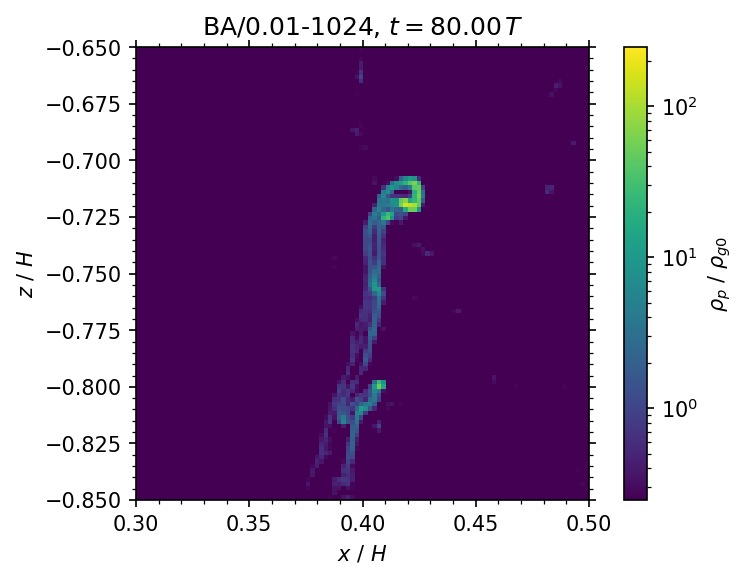

In [77]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.01-1024'
vmag = 1e3
xlim, ylim =(0.3, 0.5), (-0.85, -0.65)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00100.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

Material ⟨𝑣_𝑥⟩ = 0.042 ± 0.101 𝜂𝑣_K
Material ⟨𝑣_𝑧⟩ = 1.766 ± 0.128 𝜂𝑣_K


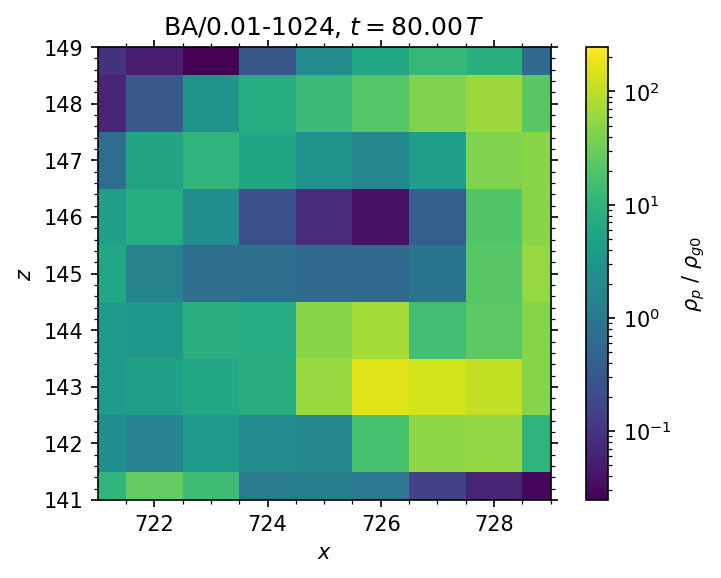

In [78]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.01-1024'
vmag = 1e4
x1, x2 = 721, 729 # 8 x 8 = 64 cells
z1, z2 = 141, 149

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
T = 2*np.pi/Omega                          # orbital period
Π = athinput['problem']['duy0']            # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed'] 
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00100.athdf')
vxavg = np.average(data['vp1'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
vzavg = np.average(data['vp2'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
σvx = np.sqrt(np.average((data['vp1'][0, z1:z2, x1:x2] - vxavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
σvz = np.sqrt(np.average((data['vp2'][0, z1:z2, x1:x2] - vzavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
print(f'Material ⟨𝑣_𝑥⟩ = {vxavg/ηv_K:.3f} ± {σvx/ηv_K:.3f} 𝜂𝑣_K')
print(f'Material ⟨𝑣_𝑧⟩ = {vzavg/ηv_K:.3f} ± {σvz/ηv_K:.3f} 𝜂𝑣_K')
vmax = np.amax(data['rhop'][0])
xf, zf = np.arange(athinput['mesh']['nx1']), np.arange(athinput['mesh']['nx2'])
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, shading='auto',
                    norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$', ylabel=r'$z$',
       xlim=(x1, x2), ylim=(z1, z2))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

#### $\Pi = 0.02$

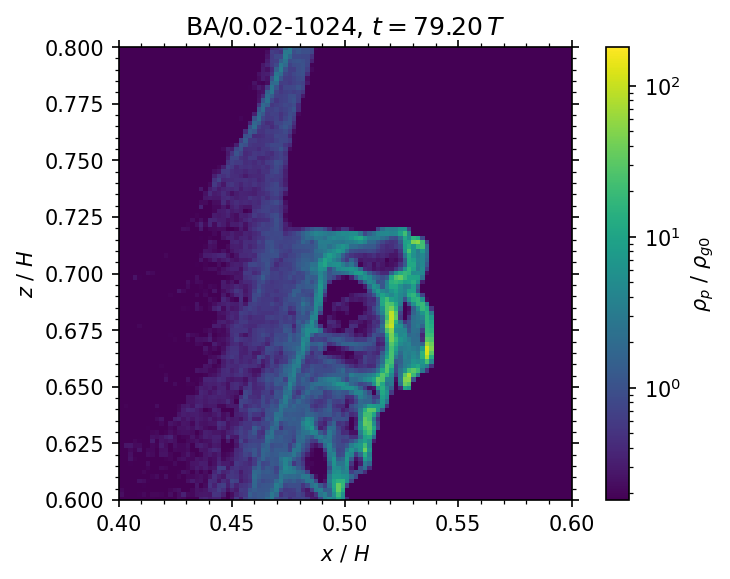

In [79]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.02-1024'
vmag = 1e3
xlim, ylim =(0.4, 0.6), (0.6, 0.8)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00099.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

Material ⟨𝑣_𝑥⟩ = 0.116 ± 0.028 𝜂𝑣_K
Material ⟨𝑣_𝑧⟩ = 1.813 ± 0.094 𝜂𝑣_K


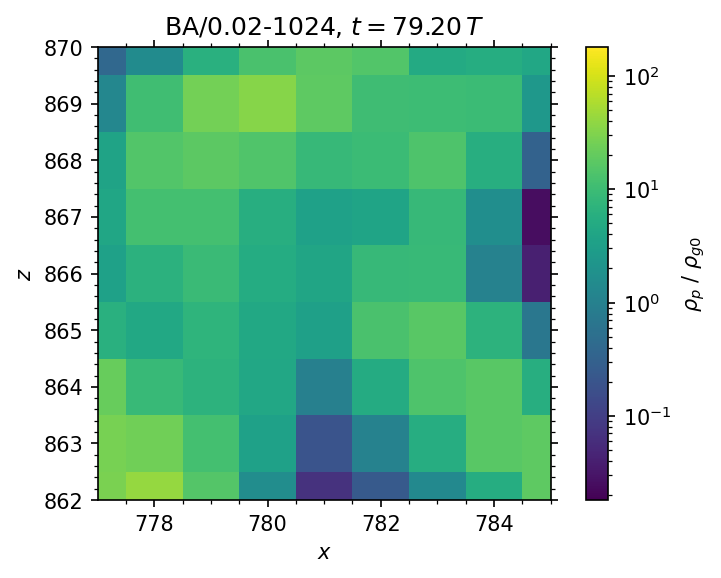

In [80]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.02-1024'
vmag = 1e4
x1, x2 = 777, 785 # 8 x 8 = 64 cells
z1, z2 = 862, 870

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
T = 2*np.pi/Omega                          # orbital period
Π = athinput['problem']['duy0']            # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed'] 
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00099.athdf')
vxavg = np.average(data['vp1'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
vzavg = np.average(data['vp2'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
σvx = np.sqrt(np.average((data['vp1'][0, z1:z2, x1:x2] - vxavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
σvz = np.sqrt(np.average((data['vp2'][0, z1:z2, x1:x2] - vzavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
print(f'Material ⟨𝑣_𝑥⟩ = {vxavg/ηv_K:.3f} ± {σvx/ηv_K:.3f} 𝜂𝑣_K')
print(f'Material ⟨𝑣_𝑧⟩ = {vzavg/ηv_K:.3f} ± {σvz/ηv_K:.3f} 𝜂𝑣_K')
vmax = np.amax(data['rhop'][0])
xf, zf = np.arange(athinput['mesh']['nx1']), np.arange(athinput['mesh']['nx2'])
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, shading='auto',
                    norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$', ylabel=r'$z$',
       xlim=(x1, x2), ylim=(z1, z2))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

#### $\Pi = 0.05$

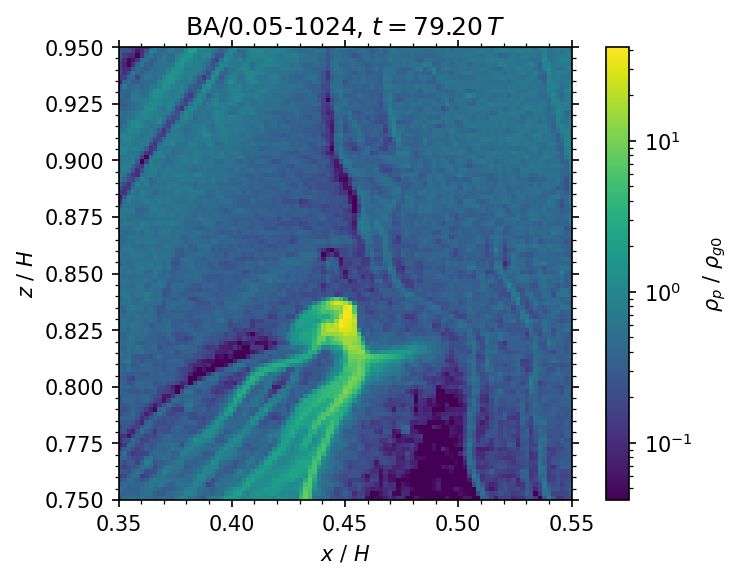

In [81]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.05-1024'
vmag = 1e3
xlim, ylim =(0.35, 0.55), (0.75, 0.95)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00099.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

Material ⟨𝑣_𝑥⟩ = 0.028 ± 0.035 𝜂𝑣_K
Material ⟨𝑣_𝑧⟩ = 1.880 ± 0.067 𝜂𝑣_K


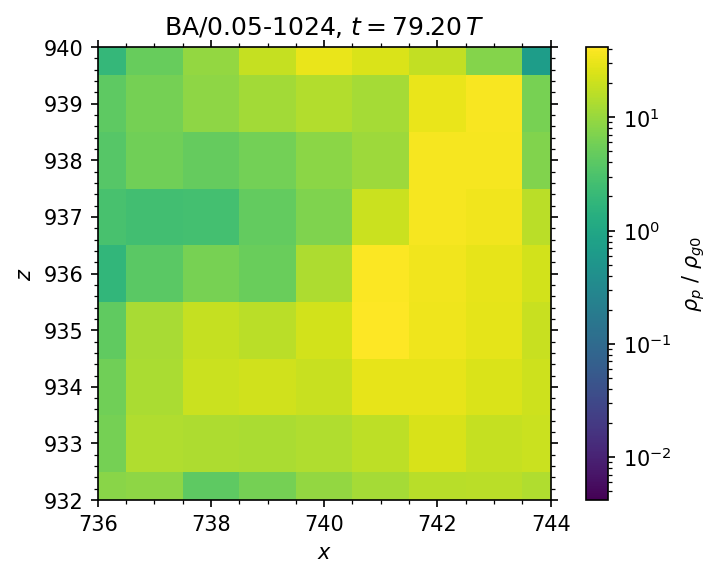

In [82]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.05-1024'
vmag = 1e4
x1, x2 = 736, 744 # 8 x 8 = 64 cells
z1, z2 = 932, 940

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
T = 2*np.pi/Omega                          # orbital period
Π = athinput['problem']['duy0']            # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed'] 
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00099.athdf')
vxavg = np.average(data['vp1'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
vzavg = np.average(data['vp2'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
σvx = np.sqrt(np.average((data['vp1'][0, z1:z2, x1:x2] - vxavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
σvz = np.sqrt(np.average((data['vp2'][0, z1:z2, x1:x2] - vzavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
print(f'Material ⟨𝑣_𝑥⟩ = {vxavg/ηv_K:.3f} ± {σvx/ηv_K:.3f} 𝜂𝑣_K')
print(f'Material ⟨𝑣_𝑧⟩ = {vzavg/ηv_K:.3f} ± {σvz/ηv_K:.3f} 𝜂𝑣_K')
vmax = np.amax(data['rhop'][0])
xf, zf = np.arange(athinput['mesh']['nx1']), np.arange(athinput['mesh']['nx2'])
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, shading='auto',
                    norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$', ylabel=r'$z$',
       xlim=(x1, x2), ylim=(z1, z2))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

#### $\Pi = 0.10$

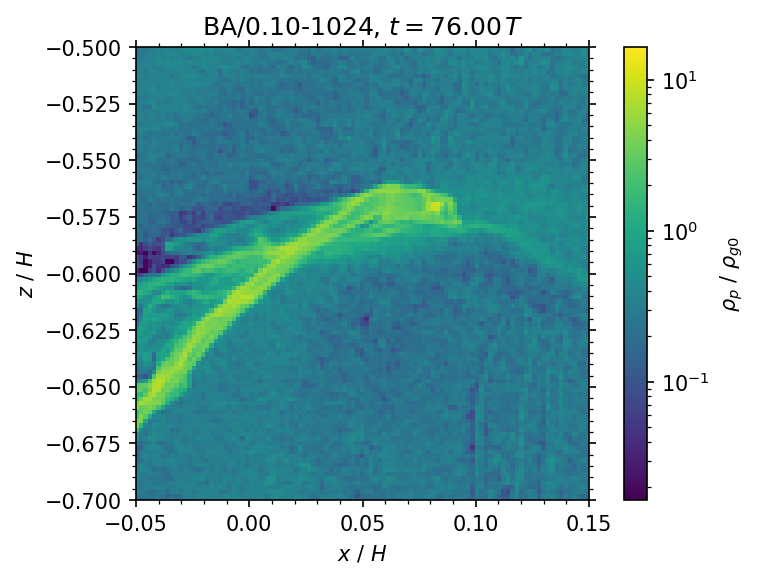

In [83]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.10-1024'
vmag = 1e3
xlim, ylim =(-0.05, 0.15), (-0.70, -0.50)

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed'] # sound speed
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
H = c_s/Omega                              # gas scale height
T = 2*np.pi/Omega                          # orbital period
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00095.athdf')
vmax = np.amax(data['rhop'][0])
xf, zf = data['x1f']/H, data['x2f']/H
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
       xlim=xlim, ylim=ylim)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

Material ⟨𝑣_𝑥⟩ = -0.351 ± 0.056 𝜂𝑣_K
Material ⟨𝑣_𝑧⟩ = 1.190 ± 0.005 𝜂𝑣_K


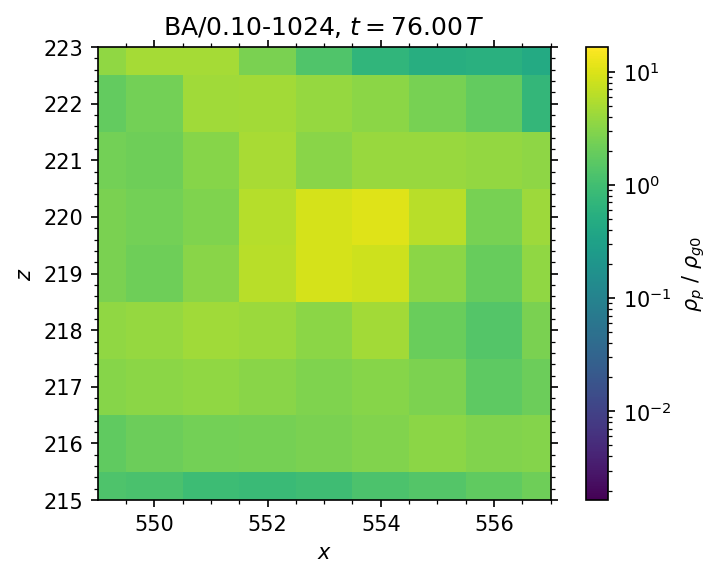

In [84]:
fig, ax = plt.subplots(dpi=150)
run = 'BA/0.10-1024'
vmag = 1e4
x1, x2 = 549, 557 # 8 x 8 = 64 cells
z1, z2 = 215, 223

athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
T = 2*np.pi/Omega                          # orbital period
Π = athinput['problem']['duy0']            # global rad. press. grad.
ηv_K = Π*athinput['hydro']['iso_sound_speed'] 
data = athena_read.athdf('../nonlinear/Pi/%s/athdf/'%run\
                            +athinput["job"]["problem_id"]+'.out1.00095.athdf')
vxavg = np.average(data['vp1'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
vzavg = np.average(data['vp2'][0, z1:z2, x1:x2],
                   weights=data['rhop'][0, z1:z2, x1:x2])
σvx = np.sqrt(np.average((data['vp1'][0, z1:z2, x1:x2] - vxavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
σvz = np.sqrt(np.average((data['vp2'][0, z1:z2, x1:x2] - vzavg)**2,
                         weights=data['rhop'][0, z1:z2, x1:x2]))
print(f'Material ⟨𝑣_𝑥⟩ = {vxavg/ηv_K:.3f} ± {σvx/ηv_K:.3f} 𝜂𝑣_K')
print(f'Material ⟨𝑣_𝑧⟩ = {vzavg/ηv_K:.3f} ± {σvz/ηv_K:.3f} 𝜂𝑣_K')
vmax = np.amax(data['rhop'][0])
xf, zf = np.arange(athinput['mesh']['nx1']), np.arange(athinput['mesh']['nx2'])
clip = np.clip(data['rhop'][0], vmax/vmag, vmax)

img = ax.pcolormesh(xf, zf, clip, shading='auto',
                    norm=colors.LogNorm(vmax/vmag, vmax))
ax.set(title=r'{:s}, $t = {:.2f}\,T$'.format(run, data['Time']/T),
       aspect='equal', xlabel=r'$x$', ylabel=r'$z$',
       xlim=(x1, x2), ylim=(z1, z2))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True)
cb = fig.colorbar(img, ax=ax)
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

## Group vs. Material Velocities Comparison

,Run,𝜂𝑣_K / HT⁻¹,"𝑣_𝑥,grp / 𝜂𝑣_K","𝜎_𝑣_𝑥,grp / 𝜂𝑣_K","𝑣_𝑧,grp / 𝜂𝑣_K","𝜎_𝑣_𝑧,grp / 𝜂𝑣_K","⟨𝑣_𝑥,mat⟩ / 𝜂𝑣_K","𝜎_𝑣_𝑥,mat / 𝜂𝑣_K","⟨𝑣_𝑧,mat⟩ / 𝜂𝑣_K","𝜎_𝑣_𝑧,mat / 𝜂𝑣_K"
0,BA/0.01-1024,0.063,0.000,0.035,1.842,0.069,0.042,0.101,1.766,0.128
1,BA/0.02-1024,0.126,-0.053,0.050,1.708,0.095,0.116,0.028,1.813,0.094
2,BA/0.05-1024,0.314,0.052,0.023,2.094,0.033,0.028,0.035,1.880,0.067
3,BA/0.10-1024,0.628,0.056,0.023,1.576,0.023,-0.351,0.056,1.190,0.005


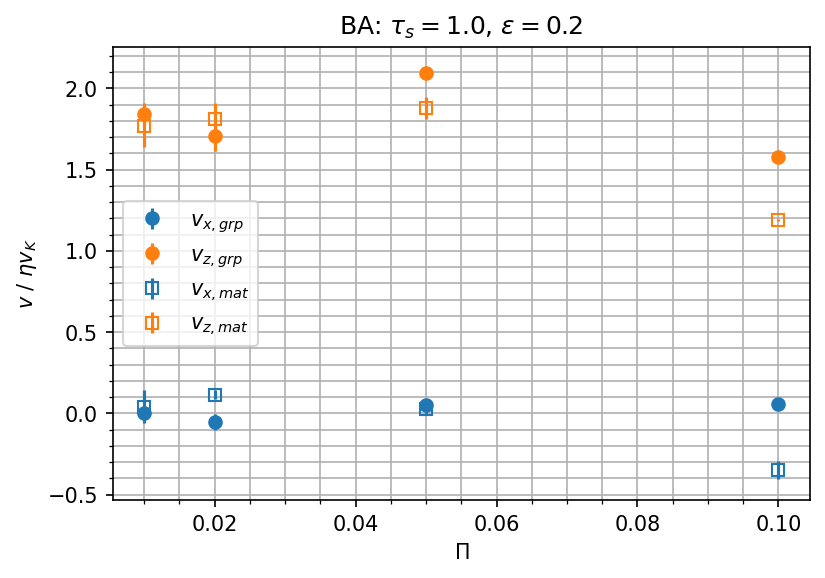

In [149]:
title = 'BA'
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
Πs, ηv_Ks = np.zeros(len(runs)), np.zeros(len(runs))
vxgrps, σvxgrps = np.zeros(len(runs)), np.zeros(len(runs)) # rad. group velocities
vzgrps, σvzgrps = np.zeros(len(runs)), np.zeros(len(runs)) # vert. group velocities
xs  = np.asarray([[0.42, 0.42], [0.55, 0.52], [0.40, 0.45], [0.07, 0.14]])    # [H]
σxs = np.asarray([[0.01, 0.01], [0.02, 0.02], [0.02, 0.01], [0.02, 0.02]])    # [H]
zs  = np.asarray([[0.50, 1.25], [-0.26, 0.71], [-0.98, 1.02], [-0.58, 1.40]]) # [H]
σzs = np.asarray([[0.02, 0.02], [0.02, 0.05], [0.03, 0.01], [0.02, 0.02]])    # [H]
ts  = np.asarray([[73.28, 79.76], [74.80, 79.32], [76.48, 79.52], [76, 78]])  # [T]
vxmats  = np.asarray([0.042, 0.116, 0.028, -0.351])        # [𝜂𝑣_K]
σvxmats = np.asarray([0.101, 0.028, 0.035, 0.056])         # [𝜂𝑣_K]
vzmats  = np.asarray([1.766, 1.813, 1.880, 1.190])         # [𝜂𝑣_K]
σvzmats = np.asarray([0.128, 0.094, 0.067, 0.005])         # [𝜂𝑣_K]

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    dt = athinput['output3']['dt']         # time between hst outputs
    i_sat = int(t_sat[i] / dt)             # output index of sat. state
    Np_tot = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3']  # total number of particles
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Ly = (athinput['mesh']['x3max'] - athinput['mesh']['x3min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    V = Lx*Ly*Lz                           # domain volume [H³]
    Πs[i] = athinput['problem']['duy0']    # global rad. press. grad.
    Ω = athinput['problem']['omega']       # local Keplerian ang. freq.
    τ_s = athinput['particles']['taus0']*Ω # dimensionless stopping time
    ε = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    ηv_K = Πs[i]*athinput['hydro']['iso_sound_speed']
    ηv_Ks[i] = ηv_K
    vxgrps[i] = (xs[i,1] - xs[i,0])/(ts[i,1] - ts[i,0])/ηv_K
    σvxgrps[i] = np.sqrt(σxs[i,1]**2 + σxs[i,0]**2)/(ts[i,1] - ts[i,0])/ηv_K
    vzgrps[i] = (zs[i,1] - zs[i,0])/(ts[i,1] - ts[i,0])/ηv_K
    σvzgrps[i] = np.sqrt(σzs[i,1]**2 + σzs[i,0]**2)/(ts[i,1] - ts[i,0])/ηv_K

fig, ax = plt.subplots(dpi=150)
ax.errorbar(Πs, vxgrps, σvxgrps, color='tab:blue', fmt='o', label=r'$v_{x,grp}$')
ax.errorbar(Πs, vzgrps, σvzgrps, color='tab:orange', fmt='o', label=r'$v_{z,grp}$')
ax.errorbar(Πs, vxmats, σvxmats, color='tab:blue', fmt='s', mfc='none',
            label=r'$v_{x,mat}$')
ax.errorbar(Πs, vzmats, σvzmats, color='tab:orange', fmt='s', mfc='none',
            label=r'$v_{z,mat}$')
ax.set(xlabel=r'$\Pi$', ylabel=r'$v$ / $\eta v_K$',
       title=r'{:s}: $\tau_s={:.1f}$, $\epsilon={:.1f}$'.format(title, τ_s, ε))
ax.minorticks_on()
ax.legend()
ax.grid(which='both')

df = pd.DataFrame({
    'Run': runs,
    '𝜂𝑣_K / HT⁻¹': ηv_Ks,
    '𝑣_𝑥,grp / 𝜂𝑣_K': vxgrps,
    '𝜎_𝑣_𝑥,grp / 𝜂𝑣_K': σvxgrps,
    '𝑣_𝑧,grp / 𝜂𝑣_K': vzgrps,
    '𝜎_𝑣_𝑧,grp / 𝜂𝑣_K': σvzgrps,
    '⟨𝑣_𝑥,mat⟩ / 𝜂𝑣_K': vxmats,
    '𝜎_𝑣_𝑥,mat / 𝜂𝑣_K': σvxmats,
    '⟨𝑣_𝑧,mat⟩ / 𝜂𝑣_K': vzmats,
    '𝜎_𝑣_𝑧,mat / 𝜂𝑣_K': σvzmats})
df.style.format({
    '𝜂𝑣_K / HT⁻¹': '{:.3f}',
    '𝑣_𝑥,grp / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑣_𝑥,grp / 𝜂𝑣_K': '{:.3f}',
    '𝑣_𝑧,grp / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑣_𝑧,grp / 𝜂𝑣_K': '{:.3f}',
    '⟨𝑣_𝑥,mat⟩ / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑣_𝑥,mat / 𝜂𝑣_K': '{:.3f}',
    '⟨𝑣_𝑧,mat⟩ / 𝜂𝑣_K': '{:.3f}',
    '𝜎_𝑣_𝑧,mat / 𝜂𝑣_K': '{:.3f}'})